In [1]:
# ============================================================
# 1. IMPORTS & CONFIG
# ============================================================
import pandas as pd
import numpy as np
results = []

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
df = pd.read_csv("C:/Users/naisa/Downloads/Naisargi Sharma_group6_Project_AI680-CS666-001-Fall-2025/spam_Emails_data.csv")

df['label_num'] = (df['label'].str.lower() == 'spam').astype(int)
df = df.dropna(subset=['text'])

X = df['text'].astype(str)
y = df['label_num']


In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)


In [4]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)


In [5]:
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid, use_proba=True):
    print(f"\n=== Training: {name} ===")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    # ROC only if model supports predict_proba
    if use_proba and hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_valid)[:, 1]
        roc = roc_auc_score(y_valid, y_proba)
    else:
        roc = None

    acc = accuracy_score(y_valid, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average='binary')

    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")
    if roc:
        print(f"ROC-AUC   : {roc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred, target_names=['Ham', 'Spam']))

    # Plot confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

    return {
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    }



=== Training: Logistic Regression ===
Accuracy  : 0.9702
Precision : 0.9640
Recall    : 0.9734
F1-score  : 0.9687
ROC-AUC   : 0.9951

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.97     15324
        Spam       0.96      0.97      0.97     13753

    accuracy                           0.97     29077
   macro avg       0.97      0.97      0.97     29077
weighted avg       0.97      0.97      0.97     29077



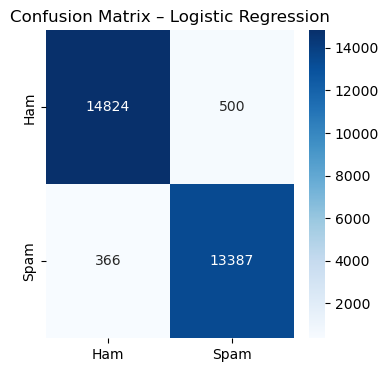


=== Training: Support Vector Machine (SVM) ===
Accuracy  : 0.9752
Precision : 0.9701
Recall    : 0.9778
F1-score  : 0.9739

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.98     15324
        Spam       0.97      0.98      0.97     13753

    accuracy                           0.98     29077
   macro avg       0.98      0.98      0.98     29077
weighted avg       0.98      0.98      0.98     29077



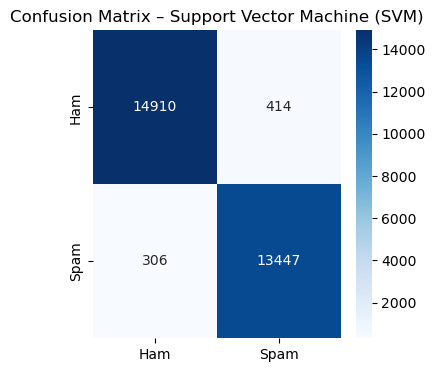


=== Training: Stacking Ensemble (LR + SVM) ===
Accuracy  : 0.9719
Precision : 0.9677
Recall    : 0.9731
F1-score  : 0.9704
ROC-AUC   : 0.9931

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.97      0.97     15324
        Spam       0.97      0.97      0.97     13753

    accuracy                           0.97     29077
   macro avg       0.97      0.97      0.97     29077
weighted avg       0.97      0.97      0.97     29077



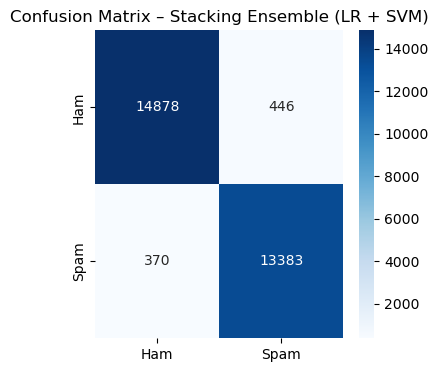

In [10]:
# Initialize results list
results = []

# Evaluate LR
res_lr = evaluate_model(
    "Logistic Regression",
    lr_pipeline,
    X_train, y_train,
    X_valid, y_valid,
    use_proba=True
)
results.append(res_lr)

# Evaluate SVM
res_svm = evaluate_model(
    "Support Vector Machine (SVM)",
    svm_pipeline,
    X_train, y_train,
    X_valid, y_valid,
    use_proba=False
)
results.append(res_svm)

# Evaluate Stacking Ensemble
res_stack = evaluate_model(
    "Stacking Ensemble (LR + SVM)",
    stack_pipeline,
    X_train, y_train,
    X_valid, y_valid,
    use_proba=True
)
results.append(res_stack)


In [11]:
results_df = pd.DataFrame(results)
results_df


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.970217,0.963995,0.973388,0.968669,0.995121
1,Support Vector Machine (SVM),0.975238,0.970132,0.977750,0.973926,NaN
2,Stacking Ensemble (LR + SVM),0.971937,0.967749,0.973097,0.970415,0.993076


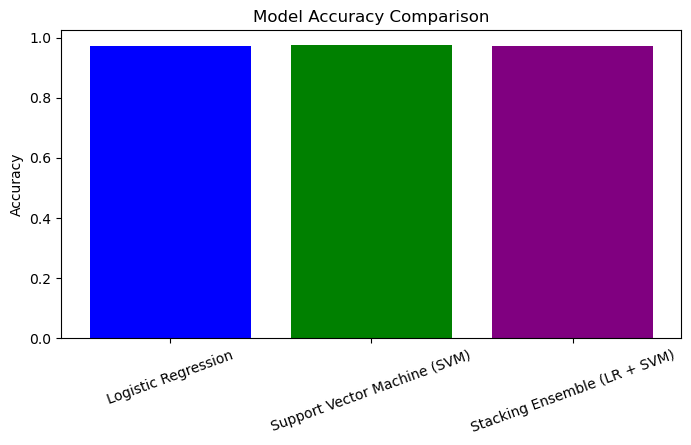

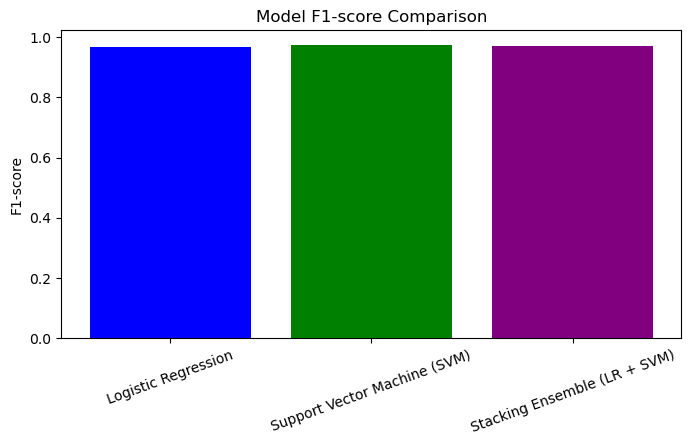

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.970217,0.963995,0.973388,0.968669,0.995121
1,Support Vector Machine (SVM),0.975238,0.970132,0.977750,0.973926,NaN
2,Stacking Ensemble (LR + SVM),0.971937,0.967749,0.973097,0.970415,0.993076


In [12]:
results_df = pd.DataFrame([res_lr, res_svm, res_stack])

plt.figure(figsize=(8,4))
plt.bar(results_df['model'], results_df['accuracy'], color=['blue','green','purple'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(results_df['model'], results_df['f1'], color=['blue','green','purple'])
plt.title("Model F1-score Comparison")
plt.ylabel("F1-score")
plt.xticks(rotation=20)
plt.show()

results_df


In [13]:
X_train_final = pd.concat([X_train, X_valid])
y_train_final = pd.concat([y_train, y_valid])

best_model = stack_pipeline
best_model.fit(X_train_final, y_train_final)

y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
roc = roc_auc_score(y_test, y_proba_test)

print("=== Final Test Performance (Stacking Ensemble) ===")
print(acc, prec, rec, f1, roc)


=== Final Test Performance (Stacking Ensemble) ===
0.9732443771923791 0.9703494272872263 0.9731714410353351 0.9717583853637287 0.9943693559049878


In [14]:
joblib.dump(best_model, "spam_stacking_final.joblib")
loaded_model = joblib.load("spam_stacking_final.joblib")


In [15]:
def predict_email(email_text):
    pred = loaded_model.predict([email_text])[0]
    proba = loaded_model.predict_proba([email_text])[0][1]
    label = "Spam" if pred == 1 else "Ham"
    print(f"Prediction: {label} (Spam probability: {proba:.3f})")

predict_email("Congratulations! You won a free iPhone. Click here!")


Prediction: Spam (Spam probability: 0.720)


In [16]:
from fastapi import FastAPI
import joblib

app = FastAPI()
model = joblib.load("spam_stacking_final.joblib")

@app.post("/predict")
def predict(email_text: str):
    pred = model.predict([email_text])[0]
    proba = model.predict_proba([email_text])[0][1]
    return {"prediction": int(pred), "spam_probability": float(proba)}


In [ ]:
# Simple chatbot in Jupyter without Flask/FastAPI

def predict_email_text(email_text: str):
    pred = model.predict([email_text])[0]
    proba = model.predict_proba([email_text])[0][1]
    label = "Spam" if pred == 1 else "Ham"
    return f"Prediction: {label} (Spam probability: {proba:.3f})"

print("Welcome to the Spam Email Classifier Chatbot! Type 'exit' to quit.")

while True:
    email_input = input("\nPlease enter an email text: ")
    if email_input.lower() == 'exit':
        print("Goodbye!")
        break
    print(predict_email_text(email_input))


Welcome to the Spam Email Classifier Chatbot! Type 'exit' to quit.



Please enter an email text:  Congratulations! you won $1,000


Prediction: Spam (Spam probability: 0.860)
